# Tutorial 2

Welcome to this second tutorial !

Here, we will implement a deep-learning model UNet to segment tumors from brain MRI imaging.

Open this notebook in Google Colab to use GPU computing and accelerate the model training. Unfortunately, you cannot connect to Colab your local environement and take benefit from the GPU in the same time. Therefore, you will have to clone the Github repo, download the Kaggle dataset, and upload the csv file generated in the previous notebooks. Concerning the needed Python packages, everything is already prepared by Colab in a Docker container.

First, clone the github repository to have access to source files : 

In [1]:
!git clone https://github.com/imcohen/segment-brain-mri.git

Cloning into 'segment-brain-mri'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 34 (delta 8), reused 28 (delta 5), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [2]:
# useful to reload automatically a module if its code has been modified 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys 
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

# change current directory  
%cd ~/../content/segment-brain-mri/notebooks/

/content/segment-brain-mri/notebooks


Download the LGG Kaggle Dataset. 

To understand the following lines, visit https://neptune.ai/blog/google-colab-dealing-with-files

In [3]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
#write kaggle API credentials to kaggle.json
!echo '{"username":"mancostart","key":"89a8f59fae9c86d5c5730fd4e97b28f3"}' > ~/.kaggle/kaggle.json 
# set permissions
!chmod 600 ~/.kaggle/kaggle.json
#install the kaggle library
!pip install kaggle 
# download LGG Kaggle Dataset
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation -p ~/../content/segment-brain-mri/data/  
# unzip
!unzip -o ~/../content/segment-brain-mri/data/lgg-mri-segmentation.zip -d ~/../content/segment-brain-mri/data/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /root/../content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/TCG

Upload "image_data.csv"

In [6]:
from google.colab import files
uploaded = files.upload()

Saving image_data.csv to image_data.csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import find_contours  
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam, lr_scheduler
from torch.nn import BCELoss
from tqdm import tqdm
from matplotlib.lines import Line2D

from sources.lgg_dataset import LGGDataset
from sources.unet import UNet

# Deep-Learning brain MRI segmentation

### Split datasets

Split the dataset into training/valid/test sets. Be careful to split by keeping the same distribution of tumors in images.

Number of images in training set :  2750
Number of images in validation set :  589
Number of images in test set :  590


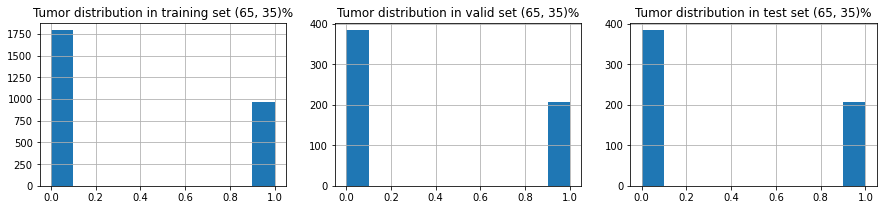

In [7]:
# read dataframe
df = pd.read_csv("image_data.csv")

# prepare train/valid/test (70%-15%-15%) sets
train_df, temp_df = train_test_split(df, train_size=0.7, stratify=df.has_tumor, random_state=0)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df.has_tumor, random_state=0)

train_df = train_df.reset_index()
valid_df = valid_df.reset_index()
test_df = test_df.reset_index()

print('Number of images in training set : ', len(train_df))
print('Number of images in validation set : ', len(valid_df))
print('Number of images in test set : ', len(test_df))

# display distributions
def distribution(df):
    return (round(100*len(df[df.has_tumor==0])/len(df)), 
            round(100*len(df[df.has_tumor==1])/len(df))) 

fig = plt.figure(figsize=(15, 3))
plt.subplot(131), 
hist=train_df.has_tumor.hist(), 
plt.title('Tumor distribution in training set {0}%'.format(distribution(train_df)))
plt.subplot(132), valid_df.has_tumor.hist(), 
plt.title('Tumor distribution in valid set {0}%'.format(distribution(valid_df)))
plt.subplot(133), test_df.has_tumor.hist(), 
plt.title('Tumor distribution in test set {0}%'.format(distribution(test_df)))
plt.show()


### Dataloaders

We will use PyTorch to design the UNet model. 

In [52]:
# hyper-parameters
learning_rate = 1e-4
epochs = 25
batch_size = 2
device = 'cuda'

#random state for repeatable experiments
#np.random.seed(0)
torch.manual_seed(0)

In [53]:
# create datasets & dataloaders
train_dataset = LGGDataset(train_df)
valid_dataset = LGGDataset(valid_df)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [54]:
# create PyTorch model 
# see https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model = UNet(in_channels=1, out_channels=1, init_features=32)

# weights initialization function
def init_weights(m):
  if type(m) == torch.nn.Conv2d:
    torch.nn.init.xavier_uniform_(m.weight)
  if type(m) == torch.nn.BatchNorm2d:
    torch.nn.init.uniform_(m.weight)
    torch.nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [55]:
# optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

# loss
loss_function = BCELoss() 

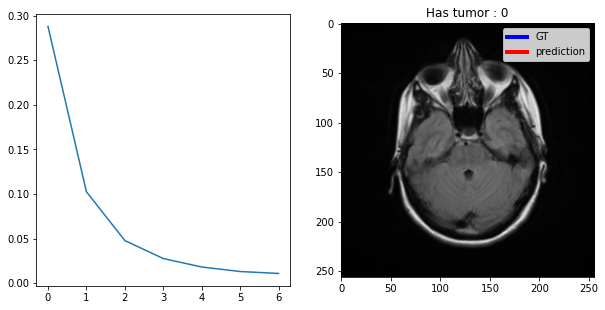

Epoch 7:  28%|██▊       | 7/25 [09:36<23:46, 79.23s/it, batch=363, avg_loss=0.00599]

KeyboardInterrupt: ignored

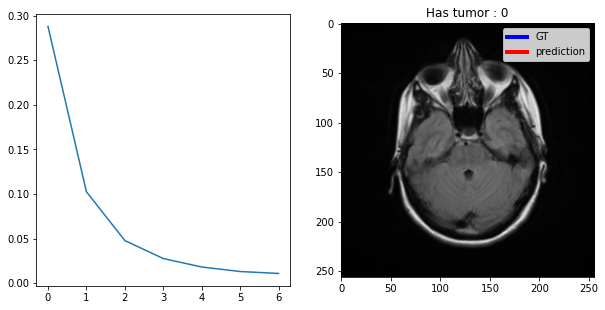

In [57]:
%matplotlib inline
from IPython import display

# training loop
historic = {'loss': []}

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4)]

pbar = tqdm(range(epochs), position=0, leave=True)
for epoch in pbar:  # loop over the dataset multiple times
    pbar.set_description('Epoch {0}'.format(epoch+1))
    
    ############ TRAINING ###########
    model.train()
    avg_loss = 0

    for i, data in enumerate(train_dataloader):
        # get the inputs
        image, mask = data

        image = image.to(device)
        mask = mask.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = model(image)
        loss = loss_function(prediction, mask)
        loss.backward()
        optimizer.step()

        # print 
        avg_loss += loss.item()
        pbar.set_postfix({'batch': i+1,
                          'avg_loss': loss.item()})
        if i%100==0:
          # display
          image_numpy = np.squeeze(image[0]).data.cpu().numpy()
          mask_numpy = np.squeeze(mask[0]).data.cpu().numpy()
          has_tumor = int(np.sum(mask_numpy.ravel()) > 0)
          predict_mask_numpy = np.squeeze(prediction[0]).data.cpu().numpy()>0.5
          ax[1].clear(), ax[1].imshow(image_numpy, 'gray')
          ax[1].contour(mask_numpy, colors='b')
          ax[1].contour(predict_mask_numpy, colors='r')
          ax[1].set_title("Has tumor : {0}".format(has_tumor))
          ax[1].legend(custom_lines, ['GT', 'prediction'])
          display.clear_output(wait=True)
          display.display(plt.gcf())

    historic['loss'].append(avg_loss/len(train_dataloader))
    ax[0].clear(), ax[0].plot(historic['loss'])

    ############ VALIDATION ###########
    #model.eval()
    
print('Finished Training')